In [30]:
import numpy as np
import h5py

In [31]:
def load_OASIS():
    with h5py.File('..\..\Datasets\OASIS_balanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('trainX'))
        trainY = np.array(G1.get('trainY'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('testX'))
        testY = np.array(G2.get('testY'))

        return trainX, trainY, testX, testY

In [32]:
def load_ADNI():
    with h5py.File('..\..\Datasets\ADNI_enhanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [33]:
dataset = 'ADNdI'
#dataset = 'ADsNI'
# read the data which is also normalized.
if dataset == 'ADNI':
    x_train, y_train, x_test, y_test = load_ADNI()
else:
    x_train, y_train, x_test, y_test = load_OASIS()

print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)

(8192, 176, 176) (8192,) (2560, 176, 176) (2560,)


In [34]:
#Dataset ready for deep learning
from tensorflow.keras.utils import to_categorical
x_train = np.expand_dims(x_train, axis=-1)
x_train = np.repeat(x_train, 3, axis=3)

x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 3, axis=3)

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

print("Test",x_test.shape)
print ("Train",x_train.shape)
print(y_train.shape)
print (y_train_cat.shape)
print (y_test_cat.shape)
row = x_train.shape[1]
col = x_test.shape[2]
print(row,col)
#print(np.max(x_train[0])) #to ensure that the values are within the range [0,1]


Test (2560, 176, 176, 3)
Train (8192, 176, 176, 3)
(8192,)
(8192, 4)
(2560, 4)
176 176


In [35]:
print(x_test.shape)
print()
epochs = 10 #hyperparameter
num_classes=4


(2560, 176, 176, 3)



In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, Activation, BatchNormalization
import tensorflow as tf
model1 = Sequential()


pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
                   input_shape=(row,col,3),
                   pooling='avg',classes=4,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model1.add(pretrained_model)
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dense(2048,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1024,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4,activation='softmax'))
model1.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_700 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_701 (Bat (None, 2048)              8192      
_________________________________________________________________
activation_696 (Activation)  (None, 2048)             

In [37]:
METRIC = tf.keras.metrics.AUC(name = 'acc')
from tensorflow.keras.optimizers import Adam # optimizer hyperparameter
model1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=METRIC) #learning rate hyperparameter.


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, Activation, BatchNormalization
import tensorflow as tf
model2 = Sequential()


pretrained_model= tf.keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=(row,col,3),
                   pooling='avg',classes=4,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model2.add(pretrained_model)
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(2048,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1024,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4,activation='softmax'))
model2.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dropout_15 (Dropout)         (None, 1536)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_906 (Bat (None, 1536)              6144      
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              3147776   
_________________________________________________________________
batch_normalization_907 (Bat (None, 2048)              8192      
_________________________________________________________________
activation_901 (Activation)  (None, 2048)             

In [39]:
METRIC = tf.keras.metrics.AUC(name = 'acc')
from tensorflow.keras.optimizers import Adam # optimizer hyperparameter
model2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=METRIC) #learning rate hyperparameter.


In [40]:
filepath = 'best_weights.hdf5'
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)
callback_list = [earlystopping, checkpoint]



In [41]:
# Training the CNN model1
print("Training the InceptionV3 model")
history1 = model1.fit(x_train, y_train_cat, batch_size=128, epochs=200, verbose=1, validation_data=(x_test, y_test_cat),callbacks=callback_list)

print("Training the InceptionResNet model")
history2 = model2.fit(x_train, y_train_cat, batch_size = 128, epochs = 200, verbose = 1, validation_data = (x_test, y_test_cat), callbacks=callback_list)

Training the InceptionV3 model
Epoch 1/200
64/64 [==============================] - 13s 162ms/step - loss: 1.3013 - acc: 0.7753 - val_loss: 2.7030 - val_acc: 0.6756

Epoch 00001: acc improved from -inf to 0.77534, saving model to best_weights.hdf5
Epoch 2/200
64/64 [==============================] - 9s 145ms/step - loss: 0.9432 - acc: 0.8590 - val_loss: 1.1726 - val_acc: 0.8264

Epoch 00002: acc improved from 0.77534 to 0.85896, saving model to best_weights.hdf5
Epoch 3/200
64/64 [==============================] - 9s 145ms/step - loss: 0.8203 - acc: 0.8849 - val_loss: 0.7276 - val_acc: 0.9076

Epoch 00003: acc improved from 0.85896 to 0.88486, saving model to best_weights.hdf5
Epoch 4/200
64/64 [==============================] - 9s 145ms/step - loss: 0.7566 - acc: 0.8997 - val_loss: 0.6305 - val_acc: 0.9292

Epoch 00004: acc improved from 0.88486 to 0.89966, saving model to best_weights.hdf5
Epoch 5/200
64/64 [==============================] - 9s 146ms/step - loss: 0.7204 - acc: 0.9062

In [42]:
models = [model1, model2]
print ("prediction by all models")
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

summed = np.sum(preds, axis=0) #computes the sum of probability by all 2 models for each class

ensemble_prediction = np.argmax(summed, axis=1) #predicts the class labels based on maximum probability.


prediction by all models


In [43]:
print("predicting classes by individual models")
prediction1 = model1.predict_classes(x_test)
prediction2 = model2.predict_classes(x_test)

print("computing accuracy by all models")
from sklearn.metrics import accuracy_score
accuracy1 = accuracy_score(y_test, prediction1)
accuracy2 = accuracy_score(y_test, prediction2)
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)


print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('ensemble accuracy =', ensemble_accuracy)

predicting classes by individual models


c:\Users\noush\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


computing accuracy by all models
Accuracy Score for model1 =  0.919140625
Accuracy Score for model2 =  0.89296875
ensemble accuracy = 0.94140625


Specificity or TNR 0.9804309598115863
Sensitivity or TPR or Recall 0.9414373324539381
FNR  0.058562667546061875
FPR 0.019569040188413656
Accuracy =  0.94140625


Text(58.222222222222214, 0.5, 'True Label')

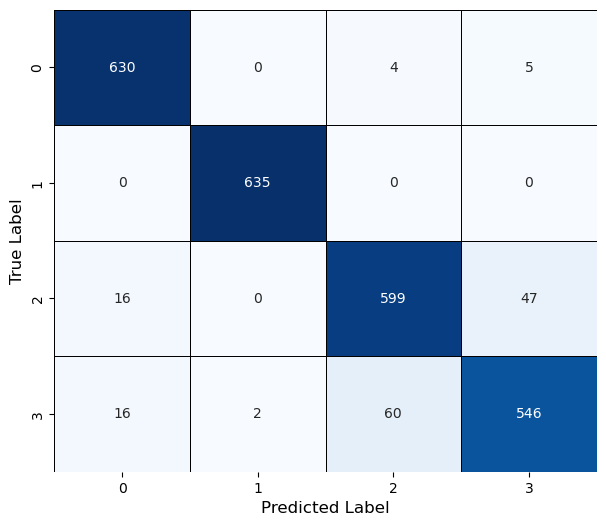

In [44]:
from sklearn.metrics import multilabel_confusion_matrix
#%%


mcm = multilabel_confusion_matrix(y_true=y_test, y_pred=ensemble_prediction, labels=[0,1,2,3], samplewise=False)
tn = mcm[:,0,0]
tp = mcm[:,1,1]
fp = mcm[:,0,1]
fn = mcm[:,1,0]
specificity = tn/(tn+fp)
print("Specificity or TNR", np.mean(specificity))

sensitivity = tp/(tp+fn)
print("Sensitivity or TPR or Recall", np.mean(sensitivity))

print("FNR ", 1-np.mean(sensitivity))

print("FPR", 1-np.mean(specificity))

from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_test, ensemble_prediction))
#%%
# # use model to predict probability that given y value is 1
# y_pred_proba = resnet_model.predict_proba(x_test)

# #calculate AUC of model
# auc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# #print AUC score
# print("AUC =",auc)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, ensemble_prediction)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)